# EDSA - Climate Change Belief Analysis 2021
### Team TS5 Classification

<div align="center" style="width: 1000px; font-size: 80%; text-align: center; margin: 0 auto">
<img src="https://raw.githubusercontent.com/CPNMorgan/Team_TS5_JHB_Classification/main/climat change.jpg"
     alt="Titanic"
     style="float: center; padding-bottom=0.5em"
     width=1000px/>

</div>

# Challenge Description

Many companies are built around lessening one’s environmental impact or carbon footprint. They offer products and services that are environmentally friendly and sustainable, in line with their values and ideals. They would like to determine how people perceive climate change and whether or not they believe it is a real threat. This would add to their market research efforts in gauging how their product/service may be received.

With this context, EDSA is challenging you during the Classification Sprint with the task of creating a Machine Learning model that is able to classify whether or not a person believes in climate change, based on their novel tweet data.

Providing an accurate and robust solution to this task gives companies access to a broad base of consumer sentiment, spanning multiple demographic and geographic categories - thus increasing their insights and informing future marketing strategies.

# Introduction

Theoretical (LogisticRegression, )
Problem/Hypothesis



We now know that the output value of a logistic regression model refers to the probability that the observation in question belongs to class 1. The output values all fall between 0 and 1, which is all very well. But at what threshold value do we decide that a probability is too low to be assigned to class 1? Usually, we pick 0.5. That is:

- Values greater than or equal to 0.5 are assigned to class 1; and
- Values less than 0.5 are assigned to class 0.

This output needs to hold for all values of X. In other words, regardless of the value of X, we need the output to be a value between 0 and 1. The function that takes care of all this is defined as follows:

$$P(X) = \displaystyle \frac{e^{\beta_0 + \beta_1 X}}{1+e^{\beta_0 + \beta_1 X}}$$

where $P(X)$ is the probability of X belonging to class 1, and $\beta_0$ and $\beta_1$ are the intercept and regression coefficient respectively, just like in a linear regression model. After a bit of manipulation we arrive at:

\begin{align}
1 - P(X) &= \displaystyle \frac{1}{1+e^{\beta_0 + \beta_1 X}} \\
\therefore \log \left( \frac{P(X)}{1-P(X)} \right) &= {\beta_0 + \beta_1 X}
\end{align}

<img src="useful_info/image5-13.jpg" align="center"/>

The term on the left is known as the **log odds ratio**. Without the log sign in front of it, it is known simply as the odds ratio. While $P(X)$ is bounded between 0 and 1, the odds ratio is bounded between 0 and $\infty$. 



# Importing Packages

In [1]:
#comet.ml
import comet_ml
from comet_ml import Experiment

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

#nlp
import string
import re    #for regex
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from PIL import Image
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer,PorterStemmer, LancasterStemmer
from nltk.tokenize import RegexpTokenizer



from nltk.tokenize import TweetTokenizer   
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_union
from wordcloud import WordCloud 
from collections import Counter
import emoji

#models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.utils import resample
from sklearn.metrics import classification_report

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# Initialising Comet.ml Experiment Tracking

In [2]:
comet_ml.init()
experiment = Experiment(
            project_name="edsa-climate-change-sentiment-analysis/Default view",
            workspace="classification-ts5",
)

COMET INFO: Comet API key is valid
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/classification-ts5/edsa-climate-change-sentiment-analysis-default-view/44be4006e6e848a9a26b0f2939eaae26



# Importing Datasets

In [3]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print('Data imported succesfully')

Data imported succesfully


# First Look at the Data

In [4]:
train_df.head()

,sentiment,message,tweetid
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221
1,1,It's not like we lack evidence of anthropogeni...,126103
2,2,RT @RawStory: Researchers say we have three ye...,698562
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954


In [5]:
test_df.head()

,message,tweetid
0,Europe will now be looking to China to make su...,169760
1,Combine this with the polling of staffers re c...,35326
2,"The scary, unimpeachable evidence that climate...",224985
3,@Karoli @morgfair @OsborneInk @dailykos \nPuti...,476263
4,RT @FakeWillMoore: 'Female orgasms cause globa...,872928


In [6]:
#check the shape of the data
train_df.shape, test_df.shape

((15819, 3), (10546, 2))

In [7]:
#unique sentiments
train_df['sentiment'].unique()

array([ 1,  2,  0, -1])

In [8]:
#samples per sentiment
train_df['sentiment'].value_counts()

 1    8530
 2    3640
 0    2353
-1    1296
Name: sentiment, dtype: int64

In [9]:
#trainig data statistics
train_df['sentiment'].describe()

count    15819.000000
mean         0.917504
std          0.836537
min         -1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: sentiment, dtype: float64

In [10]:
#checking for nulls
train_df.isnull().sum(), test_df.isnull().sum()

(sentiment    0
 message      0
 tweetid      0
 dtype: int64,
 message    0
 tweetid    0
 dtype: int64)

# DATA CLEANING

In [11]:
# creating copy of train_df
df = train_df.copy()

### Removing Noise

In [12]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def preprocess_fil(sentence):
    '''function removes noise/cleans text data'''
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"")
    cleanr = re.compile('<.*?>') 
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)
    

In [13]:
def preprocess_stemm(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(stem_words)

In [14]:
def preprocess_lemm(sentence):
    sentence=str(sentence)
    sentence = sentence.lower()
    sentence=sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url=re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words ]
    return " ".join(lemma_words)

In [15]:
# cleaning the text messages and creates a new column named 'clean_message'
df['clean_message']=df['message'].map(lambda s:preprocess_fil(s))
df.head()

,sentiment,message,tweetid,clean_message
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ma...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say three years act clima...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas racist sexist climate change d...


In [16]:
# lemmatizes the cleaned text data and creates new column named 'Lemma"
df['Lemma']=df['message'].map(lambda s:preprocess_lemm(s)) 
df.head()

,sentiment,message,tweetid,clean_message,Lemma
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ma...,polyscimajor epa chief think carbon dioxide ma...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,like lack evidence anthropogenic global warming
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say three years act clima...,rawstory researcher say three year act climate...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...,todayinmaker wired pivotal year war climate ch...
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas racist sexist climate change d...,soynoviodetodas racist sexist climate change d...


In [17]:
# stemmatize the cleaned text data and creates a new column named 'Stemm'
df['stemm']=df['message'].map(lambda s:preprocess_stemm(s)) 
df.head()

,sentiment,message,tweetid,clean_message,Lemma,stemm
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ma...,polyscimajor epa chief think carbon dioxide ma...,polyscimajor epa chief think carbon dioxid mai...
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,like lack evidence anthropogenic global warming,like lack evid anthropogen global warm
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say three years act clima...,rawstory researcher say three year act climate...,rawstori research say three year act climat ch...
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...,todayinmaker wired pivotal year war climate ch...,todayinmak wire pivot year war climat chang
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas racist sexist climate change d...,soynoviodetodas racist sexist climate change d...,soynoviodetoda racist sexist climat chang deni...


In [18]:
# proves that the lemmatization is applied to the 'clean_message' column
df['Lemma']==df['clean_message']

0         True
1         True
2        False
3         True
4        False
         ...  
15814    False
15815     True
15816    False
15817    False
15818     True
Length: 15819, dtype: bool

In [19]:
# proves that stemming is not equal to lemmatization
df['Lemma']==df['stemm']

0        False
1        False
2        False
3        False
4        False
         ...  
15814    False
15815    False
15816    False
15817    False
15818    False
Length: 15819, dtype: bool

## Exploratory Data Analysis (EDA)

 Exploratory Data Analysis (EDA) refers to the critical process of performing initial investigations on data so as to discover patterns,to spot anomalies,to test hypothesis and to check assumptions with the help of summary statistics and graphical representations

In [20]:
# Labeling the target
df['class_label'] = [['Negative(-1)', 'Neutral(0)', 'Positive(1)', 'News(2)'][x+1] for x in df['sentiment']]
df.head()

,sentiment,message,tweetid,clean_message,Lemma,stemm,class_label
0,1,PolySciMajor EPA chief doesn't think carbon di...,625221,polyscimajor epa chief think carbon dioxide ma...,polyscimajor epa chief think carbon dioxide ma...,polyscimajor epa chief think carbon dioxid mai...,Positive(1)
1,1,It's not like we lack evidence of anthropogeni...,126103,like lack evidence anthropogenic global warming,like lack evidence anthropogenic global warming,like lack evid anthropogen global warm,Positive(1)
2,2,RT @RawStory: Researchers say we have three ye...,698562,rawstory researchers say three years act clima...,rawstory researcher say three year act climate...,rawstori research say three year act climat ch...,News(2)
3,1,#TodayinMaker# WIRED : 2016 was a pivotal year...,573736,todayinmaker wired pivotal year war climate ch...,todayinmaker wired pivotal year war climate ch...,todayinmak wire pivot year war climat chang,Positive(1)
4,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ...",466954,soynoviodetodas racist sexist climate change d...,soynoviodetodas racist sexist climate change d...,soynoviodetoda racist sexist climat chang deni...,Positive(1)


#### Discreption of Sentiments:
- 2 News: the tweet links to factual news about climate change
- 1 Positive: the tweet supports the belief of man-made climate change
- 0 Neutral: the tweet neither supports nor refutes the belief of man-made climate change
- -1 Negative: the tweet does not believe in man-made climate change

#### Count of words per sentiment

In [60]:
dist = df.groupby('class_label').count()['clean_message'].reset_index().sort_values(by='clean_message',ascending=False)
dist.style.background_gradient(cmap='Blues')

,class_label,clean_message
3,Positive(1),8530
2,News(2),3640
1,Neutral(0),2353
0,Negative(-1),1296


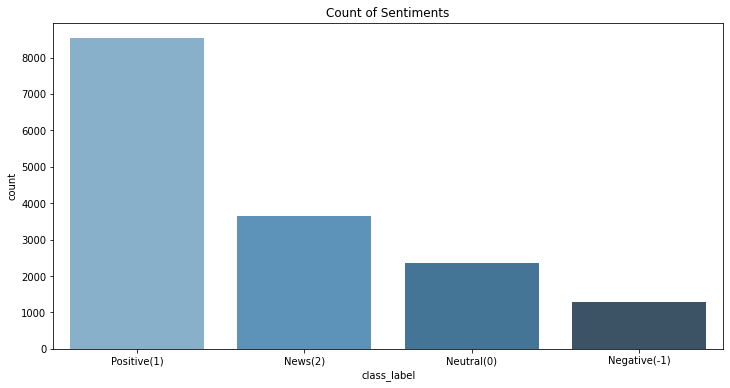

In [56]:
labels = []
plt.figure(figsize=(12,6))
sns.countplot(x='class_label',data=df, palette="Blues_d")
plt.title('Count of Sentiments')
plt.show()

## Relation between length of text and sentiment

Text(0, 0.5, 'Count of Tweets')

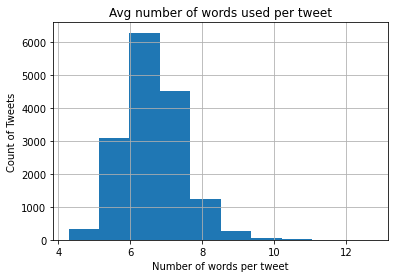

In [23]:
# average length of words overall
df['clean_message'].str.split().\
    apply(lambda x : [len(i) for i in x]).\
    map(lambda x : np.mean(x)).hist()
plt.title('Avg number of words used per tweet')
plt.xlabel('Number of words per tweet')
plt.ylabel('Count of Tweets')

### Observations
- The graph above shows that the words in the positive sentiment are higher compare to others, with 8000 words, were by the rest are below 4000

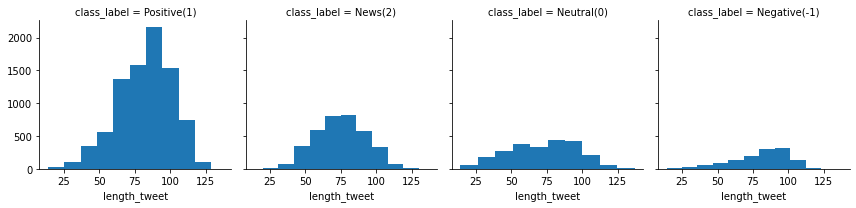

In [24]:
#Distribution of length of words per sentiment

df['length_tweet'] = df['clean_message'].apply(len)
h = sns.FacetGrid(df,col = 'class_label')
h.map(plt.hist,'length_tweet')
plt.show()

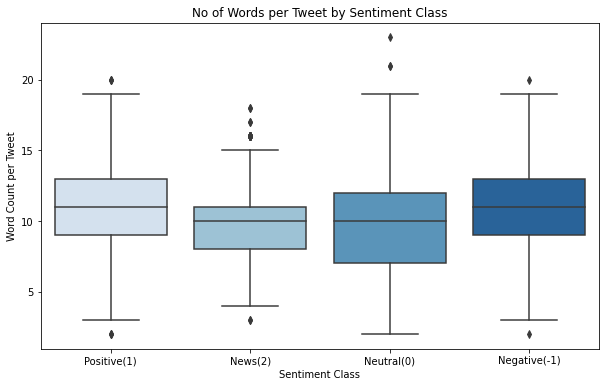

In [61]:
#Box plot visual of distribution between length of tweet vs class label
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['class_label'],
            y=df.clean_message.str.split().apply(len),
            data=df,
            palette="Blues")

plt.title('No of Words per Tweet by Sentiment Class')
plt.xlabel('Sentiment Class')
plt.ylabel('Word Count per Tweet');



## Funnel chart to get more insight from sentiments

In [71]:
fig = go.Figure(go.Funnelarea(
    text =dist.class_label,
    values = dist.clean_message,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
    ))
fig.show()

### Observation
- Negative(-1) Sentiment shows the less of counted words with the percentage of 8.19
- Neutral(0) shows 14.9 percents of counted words
- News(2) shows 23 percents of counted words
- And Positive comments shows the highest percentage of 53.9 of counted words

## checking average length of each sentiment catergory

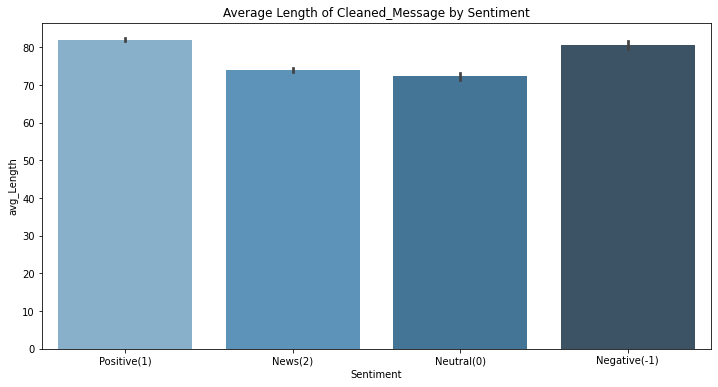

In [57]:
# avarage length of words per sentiment category
plt.figure(figsize=(12,6))
sns.barplot(x='class_label', y=df['clean_message'].apply(len) ,data = df, palette='Blues_d')
plt.ylabel('avg_Length')
plt.xlabel('Sentiment')
plt.title('Average Length of Cleaned_Message by Sentiment')
plt.show()

In [37]:
#View of average length of tweet

rel = df.groupby('sentiment').mean()
round(rel,2)

,tweetid,length_tweet,word_count
sentiment,,,
-1,499169.45,80.51,10.87
0,496550.25,72.33,9.80
1,507418.55,82.04,10.87
2,492613.50,74.04,9.98


### Observations:
 - On avarage tweet length is between 70 - 80 words for each sentiment category

## Most Common words in our Target-Selected Message

In [52]:

df['new_lis'] = df['clean_message'].apply(lambda x:str(x).split())
words = Counter([item for sublist in df['new_lis'] for item in sublist])
new = pd.DataFrame(words.most_common(20))
new.columns = ['Common_words','count']
new.style.background_gradient(cmap='Blues')

,Common_words,count
0,climate,13019
1,change,12645
2,global,3796
3,warming,3534
4,trump,2387
5,believe,1158
6,amp,940
7,world,732
8,real,720
9,going,670


In [64]:
import plotly.express as px
fig = px.bar(new, x="count", y="Common_words", color_discrete_sequence =['']*len(df), title='Commmon Words in tweet messages', orientation='h', 
             width=600, height=600)
fig.show()

### Observations:
 -

## Most common words Sentiments Wise

In [ ]:
Positive = df[df['sentiment']==1]
Negative = df[df['sentiment']==-1]
Neutral = df[train_df['sentiment']==0]
News = df[df['sentiment']==2]


### Most common positive(1) words

In [ ]:
#MosT common positive words
top = Counter([item for sublist in Positive['new_lis'] for item in sublist])
positive_w = pd.DataFrame(top.most_common(20))
positive_w.columns = ['Common_words','count']
positive_w.style.background_gradient(cmap='Greens')

In [ ]:
fig = px.bar(positive_w, x="count", y="Common_words", title='Most Commmon Positive(1) Words', orientation='h', 
             width=600, height=600)
fig.show()

### Observations:
 -

### Most common negative words

In [ ]:

top = Counter([item for sublist in Negative['new_lis'] for item in sublist])
negative = pd.DataFrame(top.most_common(20))
negative = negative.iloc[1:,:]
negative.columns = ['Common_words','count']
negative.style.background_gradient(cmap='Reds')

In [ ]:
fig = px.bar(negative, x="count", y="Common_words", title='Most Commmon Negative(-1) Words', orientation='h', 
             width=600, height=600)
fig.show()

### Observation:
 -

### Most common neutral(0) words

In [ ]:
top = Counter([item for sublist in Neutral['new_lis'] for item in sublist])
neutral = pd.DataFrame(top.most_common(20))
neutral = neutral.iloc[1:,:]
neutral.columns = ['Common_words','count']
neutral.style.background_gradient(cmap='Blues')

In [ ]:
fig = px.bar(neutral, x="count", y="Common_words", title='Most Commmon Neutral(0) Words', orientation='h', 
             width=600, height=600)
fig.show()

### Observation:
 -

### Most common news(2) words

In [ ]:
top = Counter([item for sublist in News['new_lis'] for item in sublist])
news = pd.DataFrame(top.most_common(20))
news = news.iloc[1:,:]
news.columns = ['Common_words','count']
news.style.background_gradient(cmap='Reds')

In [ ]:
fig = px.bar(news, x="count", y="Common_words", title='Most Commmon Neutral(0) Words', orientation='h', 
             width=600, height=600)
fig.show()

### Observation:
 -

### Counting number of Emojis used in the texts

In [ ]:
!pip install emoji
import emoji
emojis_df=[]
for string in df['message']:
    my_str = str(string)
    for each in my_str:
        if each in emoji.UNICODE_EMOJI['en'].keys():
            emojis_df.append(each)
freq = (Counter(i for sub in emojis_df for i in set(sub))) 
sort_orders = sorted(freq.items(), key=lambda x: x[1], reverse=True)

In [ ]:
print(sort_orders)

In [ ]:
#function for emoji extraction
def ext_emoji(s):
    return ''.join(c for c in s if c in emoji.UNICODE_EMOJI['en'].keys())

In [ ]:
#extracting emojis from train data

df['emoji'] = df['message'].apply(ext_emoji)
df[df['emoji']!='']['emoji']

### Observation:
- The most common emoji is the 'face with tears of joy' is an emoji featuring a jovial face laughing, while also crying out tears
- We have other emjis that illustrate the impacts of global warmaing on weather and climate change, e.g 'earth,fire,flowers and snowflake'

### WordCloud of most common positive words used.


In [ ]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Positive[Positive['sentiment'] == 1]
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Positive Tweets')
plt.axis("off")
plt.show()

### Observations:
 -

### WordCloud of most common negative words used

In [ ]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Negative[Negative['sentiment'] == -1]
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Negative Tweets')
plt.axis("off")
plt.show()

### Observations:
 -

### WordCloud of most common neutral words used

In [ ]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(Neutral[Neutral['sentiment'] == 0]
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('Neutral Tweets')
plt.axis("off")
plt.show()

### Observations:
 -

### WordCloud of most common neutral words used

In [ ]:
wordcloud = WordCloud(max_font_size=250,background_color='white', width=1500, height=700).generate(' '.join(News[News['sentiment'] == 2]
                                          ['clean_message']))
plt.figure( figsize=(16,10))
plt.imshow(wordcloud)
plt.title('News Tweets')
plt.axis("off")
plt.show()

### WordCloud of most common words used 'Overall'
- Wordcloud is a data visualization technique used for representing text data in which the size of each word indicates its frequency or importance

In [ ]:
train_msg = " ".join(tweet for tweet in df.clean_message)
train_wordcloud = WordCloud(max_font_size=250,
                            background_color="black",
                            width=1500,
                            height=700,
                            collocations=False,
                            colormap='Paired').generate(train_msg)
plt.figure(figsize=(16, 10))
plt.imshow(train_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

### Observation:
 - 

## Balancing Data

In [ ]:

# Separate minority and majority classes
majority_sentiment = df[df['sentiment']== 1]
minority_sentiment_0 = df[df['sentiment']== 0]
minority_sentiment_2 = df[df['sentiment']== 2]
minority_sentiment_neg1 = df[df['sentiment'] == -1]

# Upsample minority

In [ ]:
minority_sentiment_0_minority = resample(minority_sentiment_0,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=len(majority_sentiment), # match number in minority class
                          random_state=42) # reproducible results

minority_sentiment_2_minority = resample(minority_sentiment_2,
                                         replace = True,
                                         n_samples=len(majority_sentiment),
                                         random_state=42)

minority_sentiment_neg1_minority = resample(minority_sentiment_neg1,
                                   replace=True,
                                   n_samples=len(majority_sentiment),
                                   random_state=42)

# Combine upsampled minority class with majority class
df2 = pd.concat([majority_sentiment, minority_sentiment_0_minority,minority_sentiment_2_minority,minority_sentiment_neg1_minority])

# Check new class counts
df2['sentiment'].value_counts()

## downsample 

In [ ]:
# Separate minority and majority classes
majority_sentiment = df[df['sentiment']== 1]
minority_sentiment_0 = df[df['sentiment']== 0]
minority_sentiment_2 = df[df['sentiment']== 2]
minority_sentiment_neg1 = df[df['sentiment'] == -1]


Pro = resample(majority_sentiment,##PRO,
                          replace=False, # sample with replacement (we need to duplicate observations)
                          n_samples=len(minority_sentiment_neg1), # match number in minority class
                          random_state=42) # reproducible results

Neutral = resample(minority_sentiment_0,##NEUTRAL,
                                         replace = False,
                                         n_samples=len(minority_sentiment_neg1),
                                         random_state=42)

news = resample(minority_sentiment_2,##NEWS,
                                   replace=False,
                                   n_samples=len(minority_sentiment_neg1),
                                   random_state=42)

# Combine upsampled minority class with majority class
df_down = pd.concat([Pro,Neutral,news,minority_sentiment_neg1])

# Check new class counts
df_down['sentiment'].value_counts()

In [ ]:
#n_samples=len(Anti)

In [ ]:
# Show the table of balanced data in clean_text from each language Id
dist = df2.groupby('sentiment').count()['clean_message'].reset_index().sort_values(by='clean_message',ascending=True)

In [ ]:
dist

# UP AND DOWN

In [ ]:
# Separate minority and majority classes
majority_sentiment = df[df['sentiment']== 1]
minority_sentiment_0 = df[df['sentiment']== 0]
minority_sentiment_2 = df[df['sentiment']== 2]
minority_sentiment_neg1 = df[df['sentiment'] == -1]

# Downsample majority
class_size=round(len(majority_sentiment)/2)
Pro_downsampled2 = resample(majority_sentiment,
                          replace=False, # sample without replacement (no need to duplicate observations)
                          n_samples=class_size, # match number in class size
                          random_state=30) # reproducible results

# Combine downsampled majority class with minority class
#downsampled = pd.concat([not_spam_downsampled, spam])

# Upsample minority
News_upsampled = resample(minority_sentiment_2,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in  class size
                          random_state=31) # reproducible results

Neutral_upsampled = resample(minority_sentiment_0,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in  class size
                          random_state=32) # reproducible results

Anti_upsampled = resample(minority_sentiment_neg1,
                          replace=True, # sample with replacement (we need to duplicate observations)
                          n_samples=class_size, # match number in  class size
                          random_state=33) # reproducible results



# Combine upsampled minority class with majority class
upsampled_downsampled = pd.concat([News_upsampled,Neutral_upsampled,Anti_upsampled, Pro_downsampled2])
# Check new class counts
upsampled_downsampled['sentiment'].value_counts()

In [ ]:
upsampled_downsampled.head(2)

## Data Preprosessing

### Train (Validation) Test Split

In [ ]:
df['stemm']#Unbalanced

In [ ]:
df2.head()# Upsampled balanced

In [ ]:
X = df2['clean_message']
y = df2['sentiment']

### Upsampling_Downsampling our data makes model performance worse

X = upsampled_downsampled['clean_message']
y = upsampled_downsampled['sentiment']

### Down sampling our data makes model performance worst

we have very little training data here

X = df_down['clean_message']
y = df_down['sentiment']

In [ ]:
df2.shape

# Train_Test Split 

In [ ]:
ts = .1
rs = 42

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=ts, random_state=rs)

experiment.log_parameters({"test size": ts, "random state": rs})

# Classification Models 
[Back to Table of Contents](#toc)

In [ ]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
clf_dict = [LinearSVC(random_state=42), KNeighborsClassifier(n_neighbors=5),DecisionTreeClassifier(max_depth=5),
                        RandomForestClassifier(max_depth=5, n_estimators=10,
                        max_features=1), ComplementNB(), MultinomialNB(), AdaBoostClassifier()
                         ]

In [ ]:
def modeling(clf_dict, X_train, y_train, X_val, y_val):

    models = {}
    for clf in clf_dict:
        clf_text = Pipeline([('tfidf', TfidfVectorizer(min_df=1, max_df=0.1, ngram_range=(1, 2))),('clf', clf)])
        
        clf_text.fit(X_train, y_train)
        predictions = clf_text.predict(X_val)

        # Output for each model
        models[clf.__class__.__name__] = {
            'F1-Macro': metrics.f1_score(y_val,predictions,average='macro'),
            'F1-Mccuracy': metrics.f1_score(y_val, predictions,average='micro'),
            'F1-Weighted': metrics.f1_score(y_val,predictions,average='weighted')}

    return pd.DataFrame.from_dict(models, orient='index')

In [ ]:
# Displaying all the models
classi = modeling(clf_dict, X_train, y_train, X_val, y_val)
display_df = classi.sort_values('F1-Macro', ascending=False)
display_df

## Performance Visuals

In [ ]:
#Compare Performance between models visually

#fig,axis = plt.subplots(figsize=(10,5))
#rmse_x = ['LinearSVC', 'KNeighborsClassifier','DecisionTreeClassifier','RandomForestClassifier', 'ComplementNB', 'MultinomialNB', 'AdaBoostClassifier']
#rmse_y = clf_dict
#ax = sns.barplot(x=rmse_x, y=rmse_y, palette=('Blues_d'))
#plt.title('Weighted F1-Score per Model', fontsize=14)
#plt.xticks(rotation=90)
#plt.ylabel('Weighted F1-Score')
#for p in ax.patches:
#    ax.text(p.get_x() + p.get_width()/2, p.get_height(), round(p.get_height(), 2), fontsize=12, ha='center', va='bottom')
    
#plt.show()

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

### Running a Single model

In [ ]:
from sklearn.pipeline import Pipeline
param_grid = {'alpha': [0.1, 1, 5, 11]}  # parameter grid

pipeline = Pipeline([('tfidf', TfidfVectorizer(min_df=2, max_df=0.9, ngram_range=(1, 3))), ('mnb', GridSearchCV(MultinomialNB(),  param_grid=param_grid, cv=5, n_jobs=-1, scoring='f1_weighted'))])


In [ ]:
pipeline.fit(X_train,y_train)

In [ ]:
predictions = pipeline.predict(X_val)

In [ ]:
print(classification_report(predictions,y_val))

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [ ]:
experiment.log_metric("f1-Macro", f1_Macro)
experiment.log_metric("f1-Mccuracy", f1_Mccuracy)
experiment.log_metric("f1-Weighted", f1_Weighted)

In [ ]:
f1_Macro = metrics.f1_score(y_val,predictions,average='macro')
f1_Mccuracy = metrics.f1_score(y_val, predictions,average='micro'),
f1_Weighted =  metrics.f1_score(y_val,predictions,average='weighted')

## Prediction Submission csv

In [ ]:
LSVC = pd.DataFrame(data={'tweetid': test_df['tweetid'],'sentiment': predictions})

In [ ]:
LSVC.to_csv("GridSearch_MultNB_Clean_message.csv", index=False)
#OUR MODEL IMPROVED BY USING STEMMA BETTER THAN LEMMA AND WE USED UPSAMPLED DATA WITH TRAINING DATA OF 90%

In [ ]:
experiment.end()

## References
- Websites used for insipiration

- analyticsvidhya: https://www.analyticsvidhya.com/blog/2018/07/hands-on-sentiment-analysis-dataset-python/
- towardsdatascience: https://towardsdatascience.com/how-to-efficiently-remove-punctuations-from-a-string-899ad4a059fb
- codegrepper:  https://www.codegrepper.com/code-examples/python/pandas+series+remove+punctuation
- https://stackoverflow.com/questions/54396405/how-can-i-preprocess-nlp-text-lowercase-remove-special-characters-remove-numb
